In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
TRAIN_PATH = '/home/apil/data/hw_forms/train/'
TEST_PATH =  '/home/apil/data/hw_forms/test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
import glob

Using TensorFlow backend.


In [2]:
train_ids = glob.glob(TRAIN_PATH+"/images/*.jpg")
test_ids =  glob.glob(TEST_PATH+"/images/*.jpg")

In [3]:
def parseName(path):
    return path[path.rfind('/')+1:]

In [4]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, path in tqdm(enumerate(train_ids), total=len(train_ids)):
    id_ = parseName(path)
    img = imread(path)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = np.expand_dims(img, axis=-1)
    
    mask_path = TRAIN_PATH + "masks/"+id_
    mask = imread(mask_path)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) 
    Y_train[n] = np.expand_dims(mask, axis=-1)


Getting and resizing train images and masks ... 


100%|██████████| 160/160 [00:19<00:00,  8.03it/s]


In [5]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, path in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = imread(path)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = np.expand_dims(img, axis=-1)

print('Done!')

Getting and resizing test images ... 


100%|██████████| 2/2 [00:00<00:00, 47.82it/s]

Done!


In [6]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [7]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c5)

u6 = concatenate([u6, c4])

c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [8]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=20, 
                    callbacks=[earlystopper, checkpointer])

Train on 144 samples, validate on 16 samples
Epoch 1/20
144/144 [==============================] - 55s 384ms/step - loss: 0.0802 - mean_iou: 0.4609 - val_loss: 0.0406 - val_mean_iou: 0.4962
Epoch 2/20
144/144 [==============================] - 53s 371ms/step - loss: 0.0253 - mean_iou: 0.4971 - val_loss: 0.0144 - val_mean_iou: 0.4976
Epoch 3/20
144/144 [==============================] - 53s 368ms/step - loss: 0.0354 - mean_iou: 0.4980 - val_loss: 0.0217 - val_mean_iou: 0.4982
Epoch 4/20
144/144 [==============================] - 53s 369ms/step - loss: 0.0209 - mean_iou: 0.4983 - val_loss: 0.0173 - val_mean_iou: 0.4984
Epoch 5/20
144/144 [==============================] - 53s 371ms/step - loss: 0.0155 - mean_iou: 0.4984 - val_loss: 0.0133 - val_mean_iou: 0.4985
Epoch 6/20
144/144 [==============================] - 53s 371ms/step - loss: 0.0126 - mean_iou: 0.4985 - val_loss: 0.0088 - val_mean_iou: 0.4986
Epoch 7/20
144/144 [==============================] - 53s 369ms/step - loss: 0.0104 -

In [55]:
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=10, 
                    callbacks=[earlystopper, checkpointer])

Train on 144 samples, validate on 16 samples
Epoch 1/10
144/144 [==============================] - 54s 374ms/step - loss: 0.0042 - mean_iou: 0.6440 - val_loss: 0.0037 - val_mean_iou: 0.7024
Epoch 2/10
144/144 [==============================] - 53s 367ms/step - loss: 0.0040 - mean_iou: 0.7094 - val_loss: 0.0037 - val_mean_iou: 0.7106
Epoch 3/10
144/144 [==============================] - 53s 366ms/step - loss: 0.0039 - mean_iou: 0.7129 - val_loss: 0.0039 - val_mean_iou: 0.7156
Epoch 4/10
144/144 [==============================] - 53s 367ms/step - loss: 0.0037 - mean_iou: 0.7181 - val_loss: 0.0045 - val_mean_iou: 0.7198
Epoch 5/10
144/144 [==============================] - 53s 370ms/step - loss: 0.0037 - mean_iou: 0.7222 - val_loss: 0.0032 - val_mean_iou: 0.7231
Epoch 6/10
144/144 [==============================] - 53s 371ms/step - loss: 0.0035 - mean_iou: 0.7251 - val_loss: 0.0032 - val_mean_iou: 0.7258
Epoch 7/10
144/144 [==============================] - 53s 370ms/step - loss: 0.0034 -

In [56]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
threshold_pred = 0.8
preds_train_t = (preds_train > threshold_pred).astype(np.uint8)
preds_val_t = (preds_val > threshold_pred).astype(np.uint8)
preds_test_t = (preds_test > threshold_pred).astype(np.uint8)

# Create list of upsampled test masks
# preds_test_upsampled = []
# for i in range(len(preds_test)):
#     preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
#                                        (sizes_test[i][0], sizes_test[i][1]), 
#                                        mode='constant', preserve_range=True))

2/2 [==============================] - 0s 5ms/step


In [57]:
# Perform a sanity check on some random training samples
def plotOneTrainImage():
    ix = random.randint(0, len(preds_train_t))
    fig = plt.figure(figsize=(15,30))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(np.squeeze(X_train[ix]))
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(np.squeeze(Y_train[ix]))
    ax3 = fig.add_subplot(1,3,3)
    ax3.imshow(np.squeeze(preds_train_t[ix]))

    plt.show()

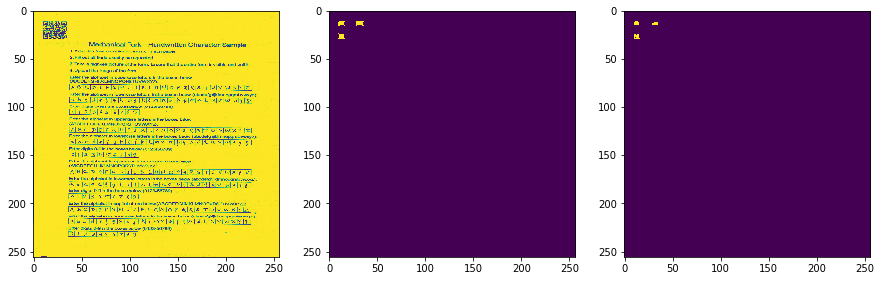

In [58]:
plotOneTrainImage()

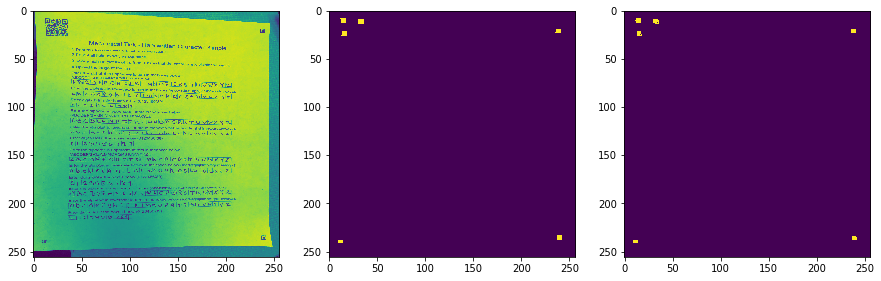

In [59]:
plotOneTrainImage()

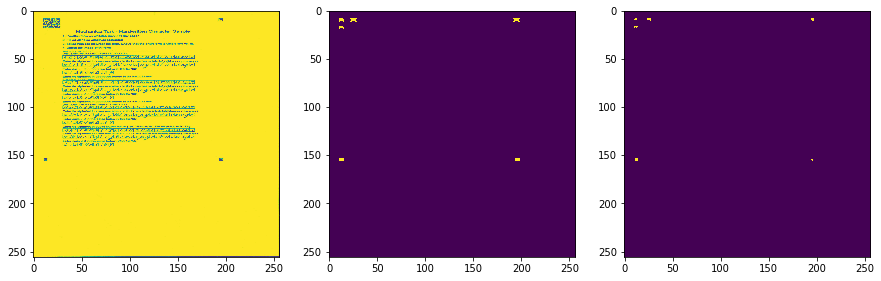

In [60]:
plotOneTrainImage()

In [61]:
def plotOneValidImage(ix):
    #ix = random.randint(0, len(preds_val_t))
    print("showing validation image {:d} of {:d}".format(ix,len(preds_val_t)))
    fig = plt.figure(figsize=(15,30))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(np.squeeze(X_train[int(X_train.shape[0]*0.9):][ix]))
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
    ax3 = fig.add_subplot(1,3,3)
    ax3.imshow(np.squeeze(preds_val_t[ix]))

    plt.show()    

showing validation image 1 of 16


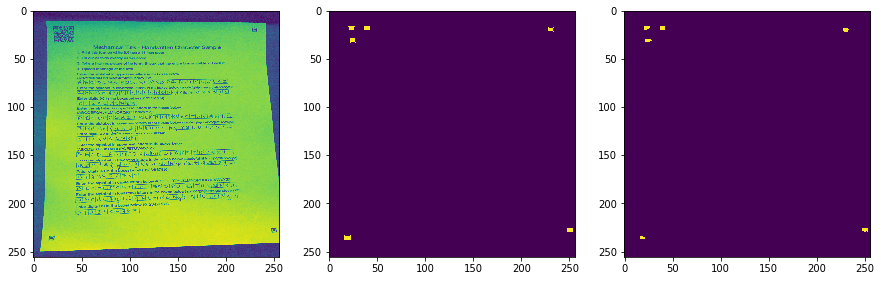

In [62]:
plotOneValidImage(1)

showing validation image 2 of 16


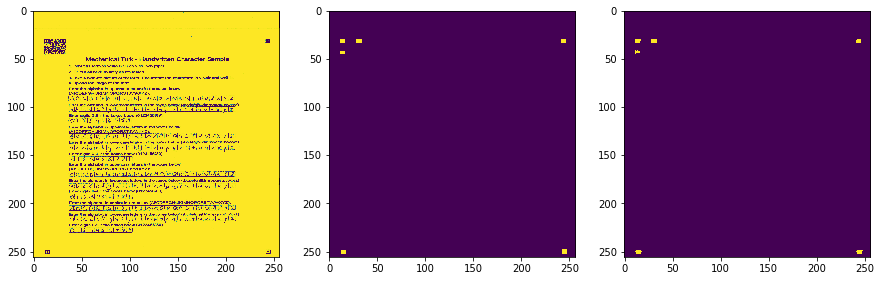

In [63]:
plotOneValidImage(2)

showing validation image 3 of 16


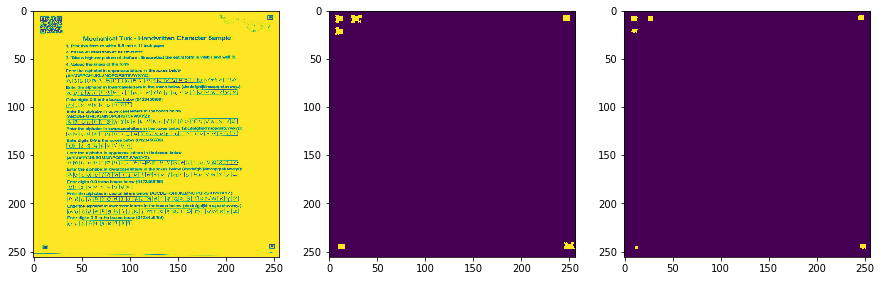

In [64]:
plotOneValidImage(3)

showing validation image 4 of 16


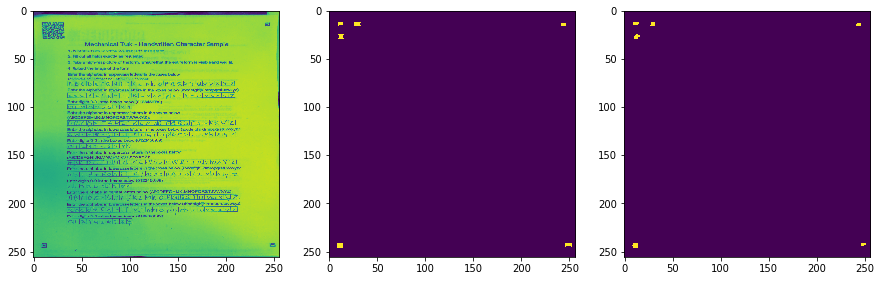

In [65]:
plotOneValidImage(4)

showing validation image 5 of 16


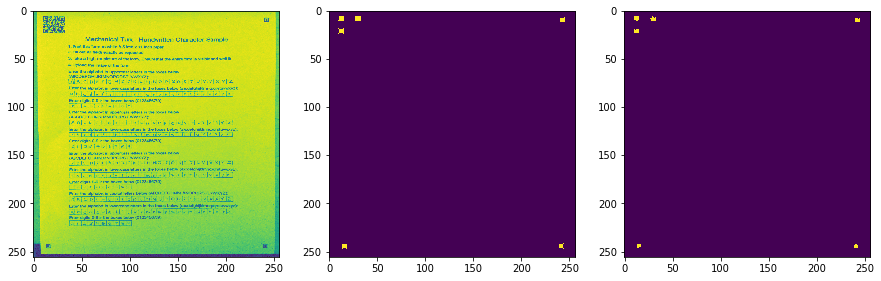

In [66]:
plotOneValidImage(5)

showing validation image 6 of 16


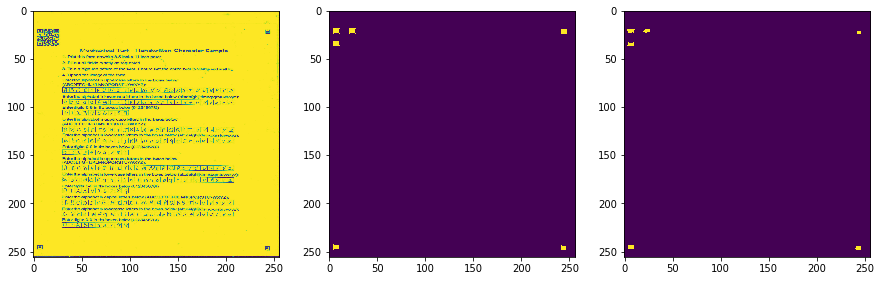

In [67]:
plotOneValidImage(6)

showing validation image 7 of 16


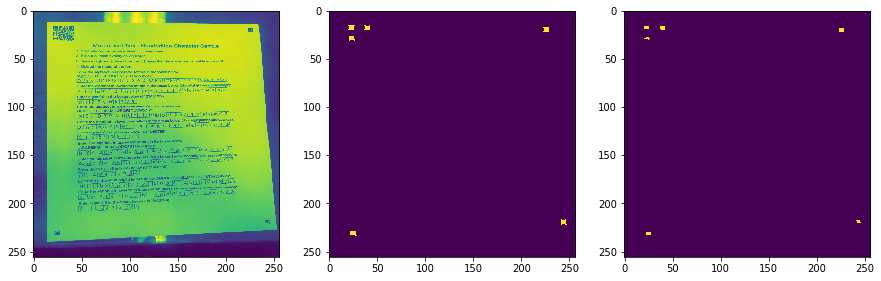

In [68]:
plotOneValidImage(7)

showing validation image 8 of 16


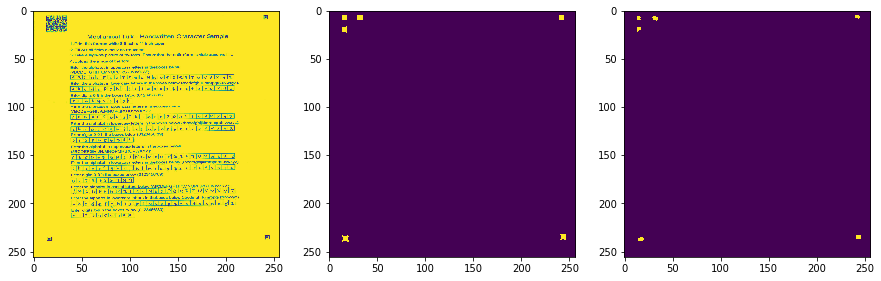

In [69]:
plotOneValidImage(8)

showing validation image 9 of 16


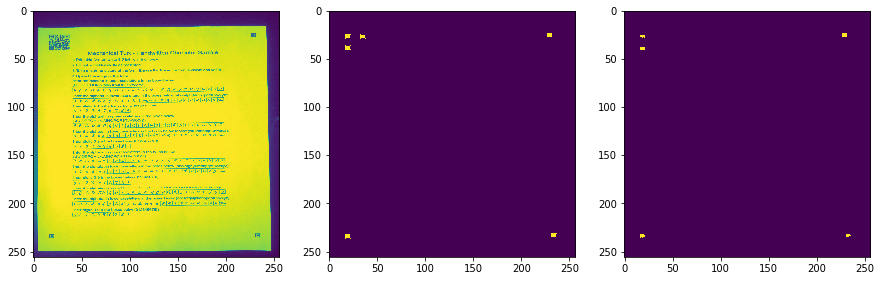

In [70]:
plotOneValidImage(9)

showing validation image 10 of 16


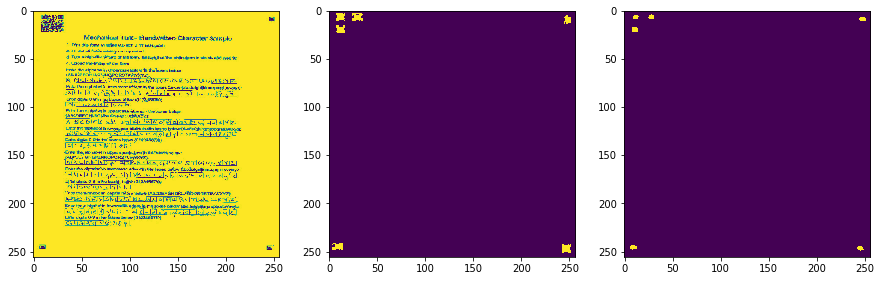

In [71]:
plotOneValidImage(10)

showing validation image 11 of 16


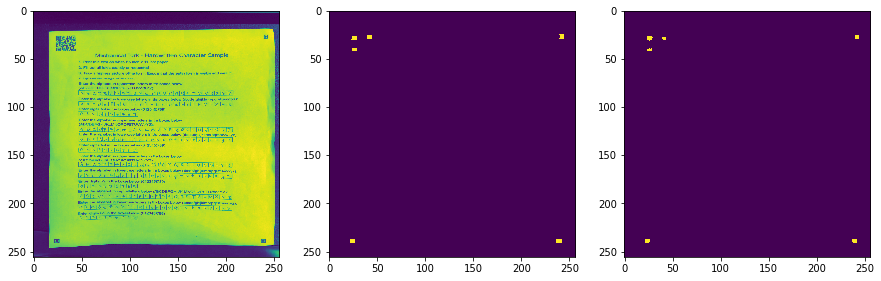

In [72]:
plotOneValidImage(11)

showing validation image 12 of 16


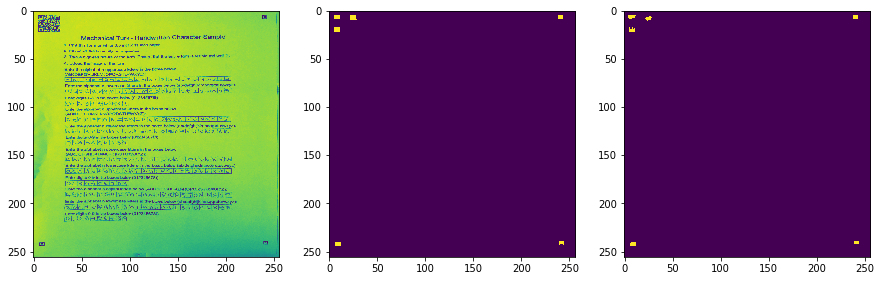

In [73]:
plotOneValidImage(12)

showing validation image 13 of 16


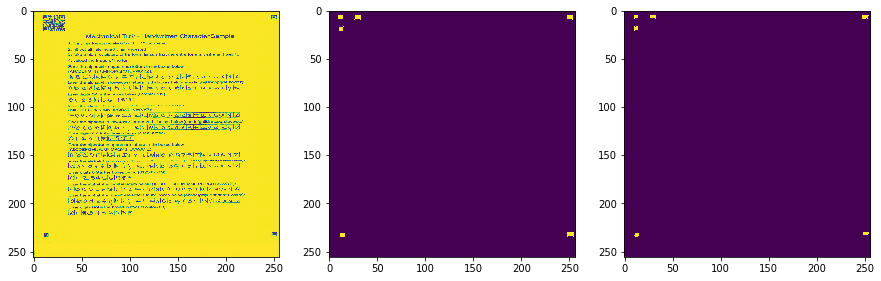

In [74]:
plotOneValidImage(13)

showing validation image 14 of 16


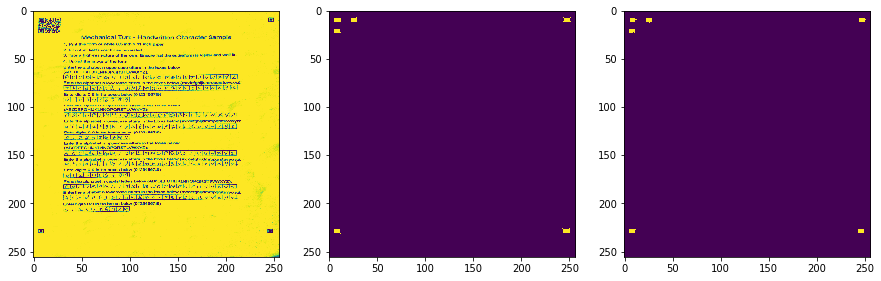

In [75]:
plotOneValidImage(14)

showing validation image 15 of 16


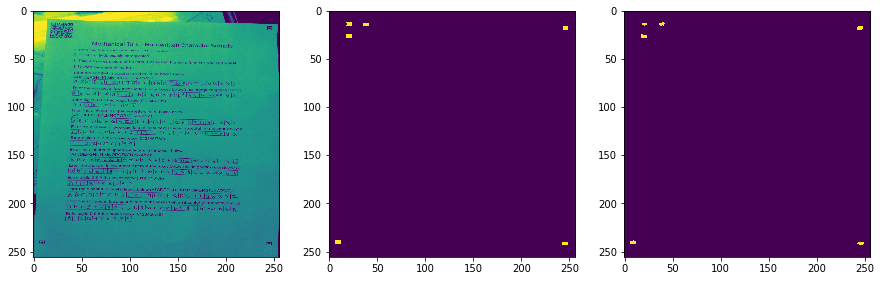

In [76]:
plotOneValidImage(15)